# Testing DEMV on _Communities&Crime_ (CRIME) dataset

Data source: [https://archive.ics.uci.edu/ml/datasets/communities+and+crime](https://archive.ics.uci.edu/ml/datasets/communities+and+crime)

- Unprivileged group: `black_people=1 && hisp_people=1`
- Positive label: 100

In [20]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

In [21]:
def prepare_data():
  '''Load the data and apply some pre-processing steps'''
  
  data = pd.read_excel('data2/crime_data_normalized.xlsx', na_values='?')
  data.drop(['state', 'county', 'community', 'communityname',
            'fold', 'OtherPerCap'], axis=1, inplace=True)
  na_cols = data.isna().any()[data.isna().any() == True].index
  data.drop(na_cols, axis=1, inplace=True)
  data = (data - data.mean())/data.std()
  y_classes = np.quantile(data['ViolentCrimesPerPop'].values, [
                          0, 0.2, 0.4, 0.6, 0.8, 1])
  i = 0
  data['ViolentCrimesClass'] = data['ViolentCrimesPerPop']
  for cl in y_classes:
    data.loc[data['ViolentCrimesClass'] <= cl, 'ViolentCrimesClass'] = i*100
    i += 1
  data.drop('ViolentCrimesPerPop', axis=1, inplace=True)
  data['black_people'] = data['racepctblack'] > -0.45
  data['hisp_people'] = data['racePctHisp'] > -0.4
  data['black_people'] = data['black_people'].astype(int)
  data['hisp_people'] = data['hisp_people'].astype(int)
  data.drop('racepctblack', axis=1, inplace=True)
  data.drop('racePctHisp', axis=1, inplace=True)
  return data


In [22]:
data = prepare_data()

In [23]:
data

,population,householdsize,racePctWhite,racePctAsian,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,...,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesClass,black_people,hisp_people
0,1.043350,-0.814793,0.599427,-0.161248,-0.542654,-0.166244,-0.277853,-0.575741,1.059815,0.682833,...,-0.193271,-0.580608,-0.058165,0.500363,0.133666,0.167274,0.940163,300.0,0,1
1,-0.453823,-1.853172,-0.056205,1.418626,-1.058133,0.669623,0.082497,-0.854782,-0.343627,0.682833,...,-1.075534,-0.131778,-0.663550,-0.413220,-0.555677,1.258716,-0.391349,500.0,1,1
2,-0.453823,-0.265063,-0.793790,0.078127,-0.220481,-0.166244,-0.337911,-0.575741,-0.499564,-1.565315,...,0.027294,0.217312,-0.461755,-0.504578,-0.112528,-0.618564,-0.391349,500.0,1,0
3,-0.138629,1.872776,-2.760686,-0.161248,0.552737,0.042723,0.022439,-1.189630,-0.031751,0.682833,...,1.074981,0.067702,-0.007717,-0.413220,0.773770,0.516536,-0.391349,300.0,1,1
4,-0.375024,0.528992,0.804312,-0.304873,-0.284915,-0.793144,-0.638204,-0.352509,-0.343627,0.458018,...,0.578708,-0.081908,-0.613101,-0.230503,-0.703394,-0.618564,-0.391349,100.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,-0.375024,-0.387225,0.476496,-0.161248,0.037258,0.112378,0.082497,-0.687357,-0.265658,0.682833,...,-1.075534,-0.730218,-1.319383,-0.504578,0.232143,-0.487591,-0.391349,200.0,1,1
1990,-0.059830,3.033317,-1.941146,3.237874,1.712562,2.550324,2.364717,-1.580287,-0.031751,0.682833,...,-2.012937,-2.625277,-3.286882,-0.413220,0.675293,0.167274,-0.391349,500.0,1,1
1991,0.806954,-0.570468,-0.261090,-0.544248,-0.478220,0.042723,-0.157736,0.652037,0.825908,0.682833,...,0.413284,0.815752,0.547219,0.134930,0.429099,0.079959,3.395139,400.0,1,1
1992,0.176566,0.284667,0.476496,0.317502,1.003780,1.714457,1.764133,-0.073469,0.202156,0.682833,...,0.027294,-0.181648,-0.663550,-0.321862,0.724532,0.734824,0.524066,300.0,0,1


In [24]:
data = data[data.ViolentCrimesClass != 100.0]

In [25]:
label = 'ViolentCrimesClass'
groups_condition = {'black_people': 1, 'hisp_people': 1}
sensitive_features = ['black_people', 'hisp_people']
positive_label = 200

In [26]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(n_jobs=-1))
])

## Logistic Regression Bias

In [27]:
model, lr_bias = cross_val(pipeline, data, label, groups_condition, sensitive_features, positive_label=positive_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [28]:
print_metrics(lr_bias)

Statistical parity:  -0.213  +-  0.06
Disparate impact:  0.254  +-  0.117
Zero one loss:  0.187  +-  0.032
F1 score:  0.499  +-  0.045
Accuracy score:  0.501  +-  0.046


## DEMV application

In [29]:
demv = DEMV(round_level=1)
demv_data = data.copy()

### Logistic regression DEMV

In [30]:
model, lr_demv = cross_val(pipeline, demv_data, label, groups_condition, sensitive_features, debiaser=demv, positive_label=100)
print_metrics(lr_demv)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Statistical parity:  0.0  +-  0.0
Disparate impact:  1.0  +-  0.0
Zero one loss:  0.196  +-  0.073
F1 score:  0.458  +-  0.035
Accuracy score:  0.457  +-  0.036


In [31]:
print_metrics(lr_demv)

Statistical parity:  0.0  +-  0.0
Disparate impact:  1.0  +-  0.0
Zero one loss:  0.196  +-  0.073
F1 score:  0.458  +-  0.035
Accuracy score:  0.457  +-  0.036


## DEMV Evaluation

In [32]:
demv.get_iters()

73

In [33]:
metrics = eval_demv(42, 164, data.copy(), pipeline, label, groups_condition, sensitive_features, positive_label=100)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

##  Blackbox Postprocessing

In [34]:
model, blackboxmetrics, pred = cross_val2(pipeline, data, label, groups_condition, sensitive_features, positive_label=positive_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.2281  0.6842
300.0  0.1800  0.3462
400.0  0.1500  0.5625
500.0  0.0984  0.5333

1
          fpr     tpr
200.0  0.0909  0.2000
300.0  0.2407  0.3182
400.0  0.3148  0.6364
500.0  0.0741  0.5909


And loss is 0.5066


Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.2115  0.6667
300.0  0.1875  0.3636
400.0  0.1273  0.6000
500.0  0.1091  0.5333

1
          fpr     tpr
200.0  0.0702  0.2222
300.0  0.2174  0.3000
400.0  0.3043  0.7000
500.0  0.0816  0.7059


And loss is 0.4779

[5.82822361e-01 1.93274614e-01 2.23903025e-01 1.40298329e-10]
[0.35892912 0.25301404 0.29714775 0.09090909]
[1.16194032e-01 4.77954910e-12 6.17139301e-01 2.66666667e-01]
[0.00177811 0.18554363 0.27934493 0.53333333]
[0.58282236 0.30783063 0.09795862 0.01138839]
[0.26806104 0.25301404 0.39673241 0.08219251]
[0.14850796 0.0543973  0.6171393  0.17995544]
[0.13318047 0.12604442 0.20744178 0.53333333]

Pre-adjustment group rates are 

0
  

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.1724  0.4000
300.0  0.2800  0.5217
400.0  0.1964  0.1765
500.0  0.1273  0.5556

1
          fpr     tpr
200.0  0.0704  0.3750
300.0  0.2222  0.3600
400.0  0.2963  0.3200
500.0  0.1552  0.8095


And loss is 0.5526


Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.1887  0.4286
300.0  0.3111  0.5000
400.0  0.2115  0.1333
500.0  0.0980  0.5000

1
          fpr     tpr
200.0  0.0794  0.5000
300.0  0.1915  0.3182
400.0  0.3191  0.3182
500.0  0.1600  0.7895


And loss is 0.5662

[0.34777403 0.35443307 0.22877024 0.06902266]
[0.25819587 0.33362162 0.23248847 0.17569403]
[0.10819637 0.24404551 0.27272727 0.37503085]
[0.05071705 0.04598741 0.17164375 0.73165179]
[0.34777403 0.29170933 0.33333333 0.02718331]
[0.26664664 0.33362162 0.31818182 0.08154992]
[0.128294   0.22194189 0.27272727 0.37703684]
[0.05037442 0.16534222 0.05263158 0.73165179]

Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.156

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.2188  0.6875
300.0  0.2333  0.2500
400.0  0.0702  0.3043
500.0  0.1864  0.6667

1
          fpr     tpr
200.0  0.0769  0.4286
300.0  0.2364  0.5294
400.0  0.3182  0.4286
500.0  0.1154  0.5000


And loss is 0.5329


Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.1897  0.6667
300.0  0.2407  0.2500
400.0  0.0833  0.3182
500.0  0.2000  0.6500

1
          fpr     tpr
200.0  0.0847  0.4286
300.0  0.2449  0.5294
400.0  0.3256  0.4348
500.0  0.0851  0.4737


And loss is 0.5368

[2.85982699e-01 3.80683968e-01 3.33333333e-01 8.52932190e-12]
[0.24521013 0.21413473 0.2557839  0.28487124]
[0.27319247 0.07786718 0.28744992 0.36149044]
[0.11037329 0.0571026  0.15462712 0.677897  ]
[0.2859827  0.36229203 0.21315231 0.13857296]
[0.37135879 0.21413473 0.30038757 0.11411891]
[0.21245989 0.11530525 0.28744992 0.38478494]
[0.06056389 0.08146981 0.18006931 0.677897  ]

Pre-adjustment group rates are 

0
          fpr     

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.1746  0.6818
300.0  0.1613  0.1304
400.0  0.1449  0.4375
500.0  0.1311  0.8750

1
          fpr     tpr
200.0  0.1111  0.2308
300.0  0.2885  0.4667
400.0  0.2182  0.3333
500.0  0.0500  0.6667


And loss is 0.4868


Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.1724  0.6842
300.0  0.1273  0.1364
400.0  0.1587  0.4286
500.0  0.1455  0.9091

1
          fpr     tpr
200.0  0.1277  0.2500
300.0  0.2857  0.3000
400.0  0.2340  0.3333
500.0  0.0588  0.6400


And loss is 0.5000

[6.66666665e-01 2.78537529e-01 5.47958052e-02 1.10716516e-09]
[0.33247781 0.51167029 0.09029191 0.06555999]
[0.1699205  0.48672762 0.17164714 0.17170474]
[0.06422655 0.09090909 0.40779774 0.43706661]
[0.66666666 0.26599217 0.02986675 0.03747441]
[0.3        0.51167029 0.14336041 0.0449693 ]
[0.41666667 0.28849816 0.17164714 0.12318804]
[0.04       0.23654543 0.28638796 0.43706661]

Pre-adjustment group rates are 

0
          fpr     

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.2778  0.7500
300.0  0.1000  0.2917
400.0  0.1746  0.3636
500.0  0.0545  0.7368

1
          fpr     tpr
200.0  0.1045  0.6364
300.0  0.1509  0.5600
400.0  0.1053  0.5238
500.0  0.1228  0.8571


And loss is 0.4079


Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.2653  0.7368
300.0  0.1064  0.3333
400.0  0.1724  0.4000
500.0  0.0400  0.7222

1
          fpr     tpr
200.0  0.1053  0.6364
300.0  0.1489  0.5714
400.0  0.0800  0.5000
500.0  0.1200  0.9444


And loss is 0.3897

[0.35786348 0.21052635 0.35724996 0.07436022]
[0.18501786 0.33333335 0.39558501 0.08606379]
[0.19426875 0.10000002 0.56536426 0.14036698]
[2.69817748e-02 5.79864092e-09 2.45189479e-01 7.27828740e-01]
[3.57863479e-01 1.82319149e-01 4.59817367e-01 5.65082982e-09]
[0.21580955 0.33333335 0.41415985 0.03669725]
[0.10525116 0.1153173  0.56536426 0.21406728]
[0.05100148 0.05104327 0.17012651 0.72782874]

Pre-adjustment group rates are 

0
  

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.2195  0.5385
300.0  0.1800  0.3529
400.0  0.2321  0.3636
500.0  0.0556  0.6923

1
          fpr     tpr
200.0  0.0395  0.6667
300.0  0.1429  0.5455
400.0  0.2542  0.4231
500.0  0.1754  0.6786


And loss is 0.4671


Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.2286  0.5000
300.0  0.1750  0.3529
400.0  0.2449  0.3750
500.0  0.0638  0.7000

1
          fpr     tpr
200.0  0.0417  0.5714
300.0  0.1552  0.5238
400.0  0.2642  0.4231
500.0  0.1852  0.6800


And loss is 0.4853

[0.49483247 0.31818182 0.08690579 0.10007992]
[0.29107792 0.35294118 0.15542368 0.20055722]
[3.71124354e-01 1.87967992e-12 2.42316559e-01 3.86559087e-01]
[1.38490405e-12 1.96050398e-12 3.20000000e-01 6.80000000e-01]
[4.94832472e-01 4.02113151e-01 1.03054377e-01 1.92843524e-12]
[0.42150581 0.35294118 0.17793397 0.04761905]
[0.21104515 0.20048445 0.24231656 0.34615385]
[0.07793046 0.08490449 0.15716505 0.68      ]

Pre-adjustment group 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.0926  0.6875
300.0  0.2340  0.5652
400.0  0.1373  0.2105
500.0  0.1724  0.7500

1
          fpr     tpr
200.0  0.1486  0.2500
300.0  0.3333  0.5600
400.0  0.1250  0.3077
500.0  0.0847  0.6957


And loss is 0.4934


Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.0980  0.7143
300.0  0.2273  0.5714
400.0  0.1087  0.2105
500.0  0.1852  0.8182

1
         fpr     tpr
200.0  0.125  0.2857
300.0  0.300  0.6190
400.0  0.102  0.3182
500.0  0.100  0.7619


And loss is 0.4632

[5.67092249e-01 1.87324542e-01 2.45583208e-01 7.75547542e-10]
[0.2203454  0.56826727 0.16042546 0.05096187]
[0.29370737 0.39695304 0.08403447 0.22530512]
[0.36501036 0.17750503 0.0196758  0.43780881]
[0.56709225 0.39341581 0.00433632 0.03515563]
[0.33333333 0.56826727 0.02074427 0.07765513]
[0.35880728 0.41725918 0.08403447 0.13989906]
[0.14068899 0.08742573 0.33407647 0.43780881]

Pre-adjustment group rates are 

0
          fpr     tpr
2

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.1111  0.7273
300.0  0.2449  0.3889
400.0  0.1800  0.4118
500.0  0.0702  0.7000

1
          fpr     tpr
200.0  0.0704  0.4286
300.0  0.2833  0.4000
400.0  0.2188  0.3810
500.0  0.0833  0.8000


And loss is 0.4671


Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.0976  0.7500
300.0  0.2391  0.4000
400.0  0.1818  0.4118
500.0  0.0769  0.6667

1
          fpr     tpr
200.0  0.0794  0.5000
300.0  0.2727  0.4000
400.0  0.2037  0.3810
500.0  0.0755  0.8182


And loss is 0.4559

[7.82069413e-01 7.12517978e-11 2.09027144e-01 8.90344341e-03]
[4.41495277e-01 2.33406293e-10 4.99148434e-01 5.93562893e-02]
[2.10070513e-01 2.71544288e-10 4.81312894e-01 3.08616593e-01]
[1.10057827e-01 1.52358769e-10 1.83704647e-01 7.06237526e-01]
[7.82069413e-01 1.53363587e-10 1.60846044e-01 5.70845430e-02]
[4.70786636e-01 2.33406293e-10 4.31633806e-01 9.75795576e-02]
[3.37747586e-01 2.52026744e-10 4.81312894e-01 1.80939519e-01]
[3.0

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.1538  0.5600
300.0  0.2581  0.3333
400.0  0.1404  0.4000
500.0  0.1500  0.5294

1
          fpr     tpr
200.0  0.1333  0.2000
300.0  0.3455  0.3500
400.0  0.2353  0.4167
500.0  0.1356  0.5000


And loss is 0.5789


Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.1633  0.6364
300.0  0.2281  0.2857
400.0  0.1569  0.4000
500.0  0.1607  0.4667

1
          fpr     tpr
200.0  0.1176  0.2143
300.0  0.3404  0.3889
400.0  0.2500  0.4286
500.0  0.1509  0.4167


And loss is 0.5809

[0.20584758 0.66264477 0.10629729 0.02521037]
[0.14378404 0.4932295  0.24221815 0.12076831]
[0.04316666 0.20274281 0.47140205 0.28268847]
[0.00961705 0.08765593 0.52760054 0.37512648]
[2.05847578e-01 7.78726302e-01 1.09501205e-10 1.54261195e-02]
[0.10188415 0.4932295  0.34047177 0.06441458]
[0.06237805 0.17571718 0.47140205 0.29050271]
[1.34892449e-10 1.54668574e-01 4.70204946e-01 3.75126480e-01]

Pre-adjustment group rates are 

0
  

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.1296  0.7500
300.0  0.1724  0.4500
400.0  0.1613  0.3125
500.0  0.1167  0.6667

1
          fpr     tpr
200.0  0.1017  0.2667
300.0  0.3333  0.4706
400.0  0.2083  0.3846
500.0  0.1207  0.6250


And loss is 0.5000


Pre-adjustment group rates are 

0
          fpr     tpr
200.0  0.1250  0.7826
300.0  0.1698  0.4444
400.0  0.1607  0.3333
500.0  0.1071  0.6667

1
          fpr     tpr
200.0  0.1154  0.3077
300.0  0.3333  0.4706
400.0  0.1860  0.4091
500.0  0.0962  0.6923


And loss is 0.4779

[2.16117006e-01 6.53448196e-01 1.30434785e-01 1.37680168e-08]
[0.12063568 0.54793665 0.22222222 0.10920545]
[0.07581161 0.32876199 0.33333333 0.26209307]
[0.038766   0.172668   0.13333333 0.65523266]
[0.21611701 0.73723933 0.02519259 0.02145107]
[0.12394947 0.54793665 0.20218603 0.12592785]
[0.09577913 0.43196772 0.33333333 0.13891982]
[1.51984631e-09 1.02763629e-01 2.42003705e-01 6.55232664e-01]

Pre-adjustment group rates are 

0
  

##  Plot

In [35]:
df = prepareplots(metrics,'crime')

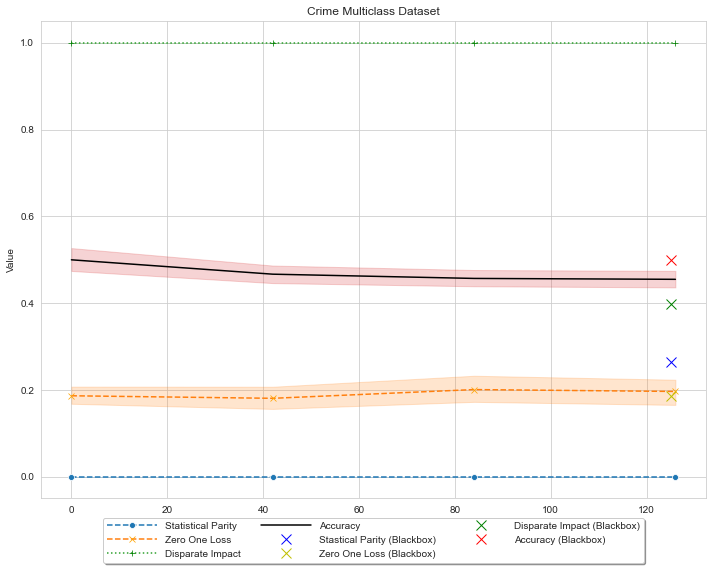

In [36]:
points = preparepoints(blackboxmetrics, 125)

plot_metrics_curves(df, points, title='Crime Multiclass Dataset')


In [37]:
unprivpergentage(data,groups_condition, demv.get_iters())

Dataset size: 1520
Unprivileged group size: 445
Percentage of unprivileged group: 29.276315789473685
Number of iterations: 73


In [38]:
save_metrics('blackbox', 'crime', blackboxmetrics)